<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/choice_of_model_to_fill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpoce of this notebook is to evaluate some different filling method depending of: the max sizes of holes (length of NaN), the distribution of holes sizes, the features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import copy as cp
from keras.preprocessing.sequence import TimeseriesGenerator
import statistics 
from scipy.ndimage.filters import uniform_filter1d
import statistics

In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

In [3]:
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go

In [4]:
df_test_rempli=pd.read_csv('/content/df_cov_continu_1_1.txt', index_col=0, parse_dates=True,sep=',')



In [5]:
mesure=["Fecha","Hora"];#0,1
mesure.append("Voltaje_(R)_[V]")#2	
mesure.append("Voltaje_(S)_[V]")#3	
mesure.append("Voltaje_(T)_[V]")#4	
mesure.append("Voltaje_(RS)_[V]")#5		
mesure.append("Voltaje_(ST)_[V]")#6		
mesure.append("Voltaje_(TR)_[V]")#7		
mesure.append("Corriente_R_[A]")#8		
mesure.append("Corriente_S_[A]")#9		
mesure.append("Corriente_T_[A]")#10		
mesure.append("Potencia_R_[VA]")#11		
mesure.append("Potencia_S_[VA]")#12		
mesure.append("Potencia_T_[VA]")#13		
mesure.append("Potencia_R_[W]")#14		
mesure.append("Potencia_S_[W]")#15	
mesure.append("Potencia_T_[W]")#16		
mesure.append("Potencia_R_[VAR]")#17		
mesure.append("Potencia_S_[VAR]")#18		
mesure.append("Potencia_T_[VAR]")#19	
mesure.append("Potencia_T_[VAR]")#20	
mesure.append("Potencia_T_[VAR]")#21	
mesure.append("Corriente_N_[A]")#22		
mesure.append("Frecuencia_[Hz]")#23		
mesure.append("not_sure_1")#24		
mesure.append("not_sure_2")#25		
mesure.append("not_sure_3")#26	
mesure.append("Potencia_3F_[KVA]")#27		
mesure.append("Potencia_3F_[W]")#28		
mesure.append("Potencia_3F_[VAR]")#29		
mesure.append("Factor de Potencia")#30	

In [6]:
df_energie_rempli=cp.deepcopy(df_test_rempli)

Utils function for the processing.

In [7]:
def polynome_de_lagrange(X,Y,x):
    L_lagrange=[1]*len(X)
    for i in range(len(X)):
        for j in range(len(X)):
            if j!=i:
                L_lagrange[i]=L_lagrange[i]*(x-X[j])/(X[i]-X[j])
    poly_inter=sum([x*y for x,y in zip(L_lagrange,Y)])
    return(poly_inter)

In [8]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
def maxi_loc(X,deg):
  N=len(X)
  Max_loc=[]
  for k in range(1,N-1):
    if np.abs(X[k])>= deg*np.abs(X[k-1]) and np.abs(X[k])>=deg*np.abs(X[k+1]):
      Max_loc.append(k)
      Max_loc.append(2*X[k])
  return(Max_loc)

In [10]:
def spectrum_take(X,freq_max):
  N=len(X)
  spectre=[0]*len(X)
  h=30/freq_max
  k1=round(len(X)/h)
  spectre[0:k1]=X[0:k1]
  spectre[len(X)-k1:len(X)]
  return(spectre)

In [11]:
def cons_sig(sigma2,deg,sig,n):
  sig2=uniform_filter1d(sig,n)
  spectre=np.fft.fft(sig2)
  Max_loc=maxi_loc(spectre,deg)
  new_spectre=np.zeros(len(spectre))
  mean=statistics.mean(sig)
  for k in range(round(len(Max_loc)/2)):
    new_spectre[Max_loc[2*k]]=Max_loc[2*k+1]
  periodic=np.real(np.fft.ifft(new_spectre))
  noise = np.random.normal(0,sigma2,len(sig2))
  sig_recons=periodic+noise
  sig_recons=sig_recons+[mean]*len(sig_recons)
  return(sig_recons)

In [12]:
def cons_sig_2(sigma2,freq_max,sig,n):
  sig2=uniform_filter1d(sig,n)
  spectre=np.fft.fft(sig2)
  spectrum_new=spectrum_take(spectre,freq_max)
  mean=statistics.mean(sig)
  periodic=2*np.real(np.fft.ifft(spectrum_new))-[mean]*len(spectrum_new)
  noise = np.random.normal(0,sigma2,len(sig2))
  sig_recons=periodic+noise
  return(sig_recons)

In [13]:
def moyenne_nan(X):
  X=list(X)
  N=len(X)
  s=0
  n=0
  for j in range(N):
      if(np.isnan(X[j]))==True:
        continue
      else:
        s+=X[j]
        n+=1
  moyenne=s/n
  return(moyenne)        

In [14]:
def median_nan(X):
  X=list(X)
  N=len(X)
  L_med=[]
  for j in range(N):
      if(np.isnan(X[j]))==True:
        continue
      else:
        L_med.append(X[j])
  L_med=L_med.sort()
  med=L_med[round(len(L_med)/2)]
  return(med)

Initialisation of dataframe for maxi_loc, spectrum_take,CNN

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
df_0 = pd.read_csv('/content/df_cov_continu_1_0.txt', index_col=0, parse_dates=True,sep=',')
N0=len(list(df_0.iloc[:,3]))
df_train=df_0.iloc[0:round(N0*0.8),:]
df_test=df_0.iloc[round(N0*0.8):N0,:]

In [17]:
Num_mes=14

In [18]:
scaler = MinMaxScaler()
RSG_train = df_train[mesure[Num_mes]].values
RSG_test = df_test[mesure[Num_mes]].values
scaler.fit(RSG_train.reshape(-1,1))

MinMaxScaler()

Setting of parameters of the distributions and of the filling methods use. The parameters use for the distributions are choosed to have a diversity of value between every distribution. The parameters of the filling method are choosed to optimize the error.

In [19]:
sigma2=100
mu=250
N_interpol=2
a=3
m=1.1
pois=10
expo_sc=10
bas=0
haut=500

Sigma2_mod=1.5
N_ma=10
deg=1
freq_max=0.15

The two function bellow respectively creates the holes depending on a distribution and its hyperparameters and files the holes following a certain method with its parameters.

In [20]:
def create_holes(sigma2,mu,limite,a,m,pois,expo_sc,bas,haut,distrib,df_energie_rempli,N_interpol):
  Nombre_lon=len(list(df_energie_rempli.loc[:,mesure[Num_mes]]))
  df_vide=cp.deepcopy(df_energie_rempli)
  j=20
  number_of_holes=0
  if(distrib=="norm"):
    while(j<Nombre_lon-10):
      H=np.random.normal(loc=mu, scale=sigma2, size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="expo"):
    while(j<Nombre_lon-10):
      H=np.random.exponential(scale=expo_sc, size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="pareto"):
    while(j<Nombre_lon-10):
      H =(np.random.pareto(a, size=None) + 1) * m
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="poisson"):
    while(j<Nombre_lon-10):
      H=np.random.poisson(pois,size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="uniform"):
    while(j<Nombre_lon-10):
      H=np.random.uniform(low=bas, high=haut,size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  return df_vide,number_of_holes        

In [21]:
def rempli_global(methode_rempli,N_interpol,Sigma2_mod,N_mov_av,deg,freq_max,df_vide,Num_mes,df_train,df_0):
  Num_mes=Num_mes-2
  if(methode_rempli=="lagrange"):
    new_df=df_vide
    H=list(df_vide.iloc[:,14])
    Long_data=len(H)
    X=list(range(N_interpol))
    inv=list(reversed(list(range(1,N_interpol+1))))
    j=0
    while j<len(H)-round(N_interpol/2)-1:
      if np.isnan(H[j])==True:
        u=cp.deepcopy(j)
        while ((np.isnan(H[j])) and j !=len(H)-round(N_interpol/2)-1)==True:
            j+=1
        ecart=abs(u-j)
        X1=list(range(u-round(N_interpol/2),u))
        X2=list(range(u+ecart,u+ecart+round(N_interpol/2)))
        X=X1+X2
        for k in range(u,j):
          Y=[new_df.iloc[x,Num_mes] for x in X]
          new_df.iloc[k,Num_mes]=polynome_de_lagrange(X, Y, k)
      j+=1
      if(j==len(H)):
          break
  elif(methode_rempli=="mean"):
    new_df=df_vide
    H=list(df_vide.iloc[:,14])
    Long_data=len(H)
    moy=moyenne_nan(new_df.iloc[:,Num_mes])
    if(np.isnan(moy)==True):
      moy=new_df.iloc[0,Num_mes]
    for k in range(Long_data):
      if np.isnan(new_df.iloc[k,Num_mes])==True:
        new_df.iloc[k,Num_mes]=moy
  elif(methode_rempli=="median"):
    new_df=df_vide
    H=list(df_vide.iloc[:,14])
    Long_data=len(H)
    median= statistics.median(new_df.iloc[:,Num_mes])
    if(np.isnan(median)==True):
      median=new_df.iloc[0,Num_mes]
    for k in range(Long_data):
      if np.isnan(new_df.iloc[k,Num_mes])==True:
        new_df.iloc[k,Num_mes]=median
  elif(methode_rempli=="CNN"):
    scaler = MinMaxScaler()
    RSG_train = df_train[mesure[Num_mes]].values
    scaler.fit(RSG_train.reshape(-1,1))
    scaled_train = scaler.transform(RSG_train.reshape(-1,1))
    n_steps=20
    n_features=1
    X,y=split_sequence(scaled_train,n_steps)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    X = X.reshape(X.shape[0], X.shape[1], n_features)
    model.fit(X, y, epochs=50, verbose=0,batch_size=100)
    new_df=cp.deepcopy(df_vide)
    batch_predict=scaler.transform(np.array(new_df.iloc[:,Num_mes]).reshape(-1,1))
    H=list(df_vide.iloc[:,Num_mes])
    Long_data=len(H)
    for j in range(19,Long_data):
      if np.isnan(new_df.iloc[j,Num_mes])==True:
        current_batch = batch_predict[j-19:j+1].reshape((1, n_steps, n_features))
        predict=model.predict(current_batch)
        batch_predict[j]=predict
        new_df.iloc[j,Num_mes]=float(scaler.inverse_transform(predict))
  elif(methode_rempli=="maxi_loc"):
    new_df=df_vide
    extrait=list(df_0.iloc[:,Num_mes])
    H=list(df_vide.iloc[:,Num_mes])
    Long_data=len(H)
    semaine_extraite=extrait[0:7*720]
    temp1=semaine_extraite[0:165-2*720]
    temp2=semaine_extraite[165-2*720:]
    semaine_extraite_fin=temp2+temp1
    recons_sem_1a=list(cons_sig(Sigma2_mod,deg,semaine_extraite_fin[0:5*720],N_mov_av))
    recons_sem_1b=list(cons_sig(Sigma2_mod,deg,semaine_extraite_fin[5*720:],N_mov_av))
    recons_sem_1=recons_sem_1a+recons_sem_1b
    Q=round(Long_data/(720*7))
    R=Long_data%(720*7)
    recons_sig_1=recons_sem_1*Q + recons_sem_1[0:R+2]
    for j in range(0,Long_data):
      if np.isnan(new_df.iloc[j,Num_mes])==True:
        new_df.iloc[j,Num_mes]=recons_sig_1[j]
  elif(methode_rempli=="spectrum_take"):
    new_df=df_vide
    extrait=list(df_0.iloc[:,Num_mes])
    H=list(df_vide.iloc[:,Num_mes])
    Long_data=len(H)
    semaine_extraite=extrait[0:7*720]
    temp1=semaine_extraite[0:165-2*720]
    temp2=semaine_extraite[165-2*720:]
    semaine_extraite_fin=temp2+temp1
    recons_sem_2=list(cons_sig_2(Sigma2_mod,freq_max,semaine_extraite_fin,N_mov_av))
    Q=round(Long_data/(720*7))
    R=Long_data%(720*7)
    recons_sig_2=recons_sem_2*Q + recons_sem_2[0:R+2]
    for j in range(0,Long_data):
      if np.isnan(new_df.iloc[j,Num_mes])==True:
        new_df.iloc[j,Num_mes]=recons_sig_2[j]
  else:
    print("erreur rentrée") 
  return(new_df.iloc[:,Num_mes])  

On this part, we shows the different distribution used to create the holes with the parameter selected before

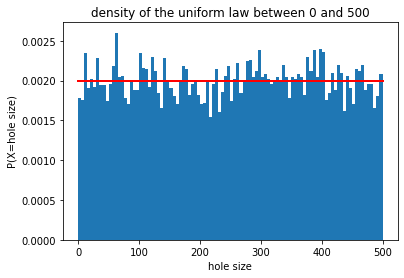

In [22]:
s = np.random.uniform(bas,haut,10000)
count, bins, ignored = plt.hist(s, 100, density=True)
plt.plot(bins, np.ones_like(bins)*1/500, linewidth=2, color='r')
plt.xlabel("hole size")
plt.ylabel("P(X=hole size)")
plt.title("density of the uniform law between 0 and 500")
plt.show()

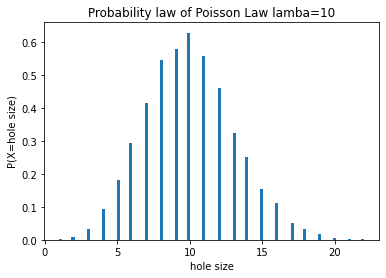

In [23]:
s_poi = np.random.poisson(10, 10000)
count, bins, ignored = plt.hist(s_poi, 100, density=True)
plt.xlabel("hole size")
plt.ylabel("P(X=hole size)")
plt.title("Probability law of Poisson Law lamba=10")
X=np.linspace(10,60,50)

plt.show()


In [24]:
from scipy.stats import norm

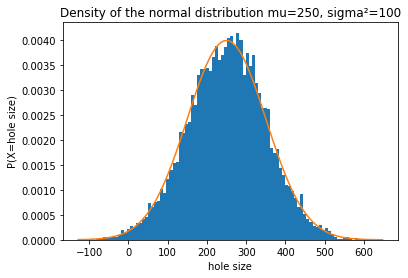

In [25]:
s_norm=np.random.normal(loc=mu,scale=sigma2, size=10000)
count, bins, ignored = plt.hist(s_norm, 100, density=True)
sd=np.sqrt(sigma2)
plt.plot(bins,norm.pdf(bins,mu,sigma2))
plt.xlabel("hole size")
plt.ylabel("P(X=hole size)")
plt.title("Density of the normal distribution mu=250, sigma²=100")
plt.show()

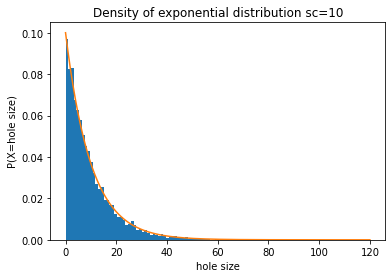

In [26]:
s_expo=np.random.exponential(scale=expo_sc, size=10000)
X=np.linspace(0,120,10000)
Y=(1/expo_sc)*np.exp(-X/expo_sc)
count, bins, ignored = plt.hist(s_expo, 100, density=True)
plt.plot(X,Y)
plt.xlabel("hole size")
plt.ylabel("P(X=hole size)")
plt.title("Density of exponential distribution sc=10")
plt.show()

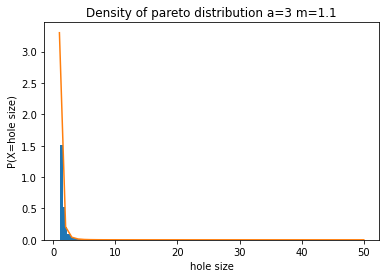

In [27]:
s_pareto=(np.random.pareto(a, size=10000) + 1) * m
X=np.linspace(1,50)
Y=a*m/(X**(a+1))
count, bins, ignored = plt.hist(s_pareto, 100, density=True)
plt.plot(X,Y)
plt.xlabel("hole size")
plt.ylabel("P(X=hole size)")
plt.title("Density of pareto distribution a=3 m=1.1")
plt.show()

In [28]:
precedent_result=[]

In [29]:
import json

In [30]:
with open("./drive/MyDrive/DatosInvestigacion/Hole_filling_method.txt",'r') as fp:
    for line in fp:
      precedent_result.append(json.loads(line))

In [31]:
df_precedent_result = pd.DataFrame(precedent_result)

In [32]:
already_happen_combination=[]

In [33]:
df_result=df_precedent_result

In [34]:
for i in range(len(df_result)):
  already_happen_combination.append((str(df_result.iloc[i]['Feature']),
                                   int(df_result.iloc[i]['max hole size']),
                                   str(df_result.iloc[i]['distribution']),
                                   str(df_result.iloc[i]['Filing method'])))

In [35]:
feature=[28,26,27,10,11,13,8,12,19]
lim_list=[5,10,50,100,500]
distrib_list=["norm","expo","pareto","poisson","uniform"]
methode_rempli_list=["lagrange","mean","median","CNN","maxi_loc","spectrum_take"]

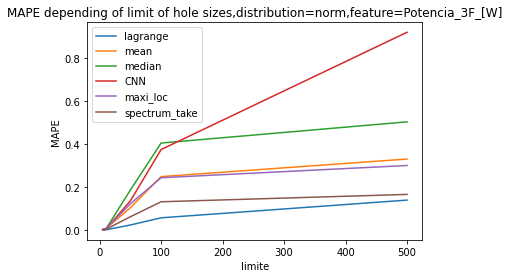

In [36]:
df_plot=df_result.loc[df_result["distribution"]=="norm"]
df_plot=df_plot.loc[df_plot["Feature"]==mesure[28]]
X=[5,10,50,100,500]
Y=[]
for j in methode_rempli_list:
  Y.append(df_plot.loc[df_plot["Filing method"]==j])
plt.plot(X,Y[0].iloc[:,8],label="lagrange")
plt.xlabel("limite")
plt.ylabel("MAPE")
plt.title("MAPE depending of limit of hole sizes,distribution=norm,feature="+mesure[28])
plt.plot(X,Y[1].iloc[:,8],label="mean")
plt.plot(X,Y[2].iloc[:,8],label="median")
plt.plot(X,Y[3].iloc[:,8],label="CNN")
plt.plot(X,Y[4].iloc[:,8],label="maxi_loc")
plt.plot(X,Y[5].iloc[:,8],label="spectrum_take")
plt.legend()
plt.show()

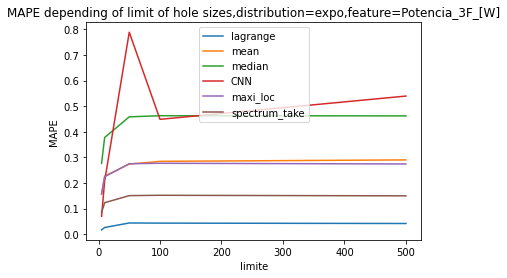

In [37]:
df_plot=df_result.loc[df_result["distribution"]=="expo"]
df_plot=df_plot.loc[df_plot["Feature"]==mesure[28]]
X=[5,10,50,100,500]
Y=[]
for j in methode_rempli_list:
  Y.append(df_plot.loc[df_plot["Filing method"]==j])
plt.plot(X,Y[0].iloc[:,8],label="lagrange")
plt.xlabel("limite")
plt.ylabel("MAPE")
plt.title("MAPE depending of limit of hole sizes,distribution=expo,feature="+mesure[28])
plt.plot(X,Y[1].iloc[:,8],label="mean")
plt.plot(X,Y[2].iloc[:,8],label="median")
plt.plot(X,Y[3].iloc[:,8],label="CNN")
plt.plot(X,Y[4].iloc[:,8],label="maxi_loc")
plt.plot(X,Y[5].iloc[:,8],label="spectrum_take")
plt.legend()
plt.show()

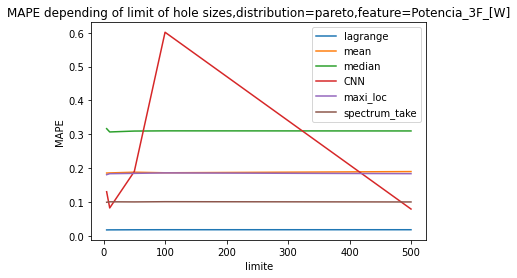

In [38]:
df_plot=df_result.loc[df_result["distribution"]=="pareto"]
df_plot=df_plot.loc[df_plot["Feature"]==mesure[28]]
X=[5,10,50,100,500]
Y=[]
for j in methode_rempli_list:
  Y.append(df_plot.loc[df_plot["Filing method"]==j])
plt.plot(X,Y[0].iloc[:,8],label="lagrange")
plt.xlabel("limite")
plt.ylabel("MAPE")
plt.title("MAPE depending of limit of hole sizes,distribution=pareto,feature="+mesure[28])
plt.plot(X,Y[1].iloc[:,8],label="mean")
plt.plot(X,Y[2].iloc[:,8],label="median")
plt.plot(X,Y[3].iloc[:,8],label="CNN")
plt.plot(X,Y[4].iloc[:,8],label="maxi_loc")
plt.plot(X,Y[5].iloc[:,8],label="spectrum_take")
plt.legend()
plt.show()

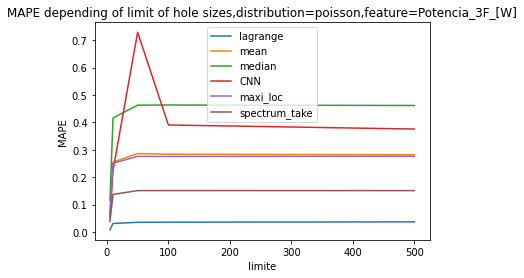

In [39]:
df_plot=df_result.loc[df_result["distribution"]=="poisson"]
df_plot=df_plot.loc[df_plot["Feature"]==mesure[28]]
X=[5,10,50,100,500]
Y=[]
for j in methode_rempli_list:
  Y.append(df_plot.loc[df_plot["Filing method"]==j])
plt.plot(X,Y[0].iloc[:,8],label="lagrange")
plt.xlabel("limite")
plt.ylabel("MAPE")
plt.title("MAPE depending of limit of hole sizes,distribution=poisson,feature="+mesure[28])
plt.plot(X,Y[1].iloc[:,8],label="mean")
plt.plot(X,Y[2].iloc[:,8],label="median")
plt.plot(X,Y[3].iloc[:,8],label="CNN")
plt.plot(X,Y[4].iloc[:,8],label="maxi_loc")
plt.plot(X,Y[5].iloc[:,8],label="spectrum_take")
plt.legend()
plt.show()

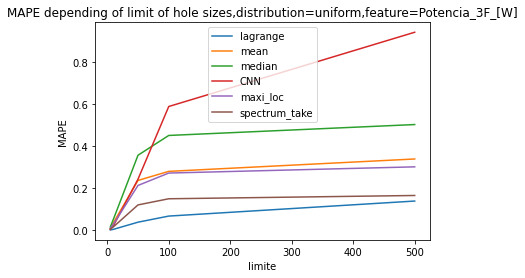

In [40]:
df_plot=df_result.loc[df_result["distribution"]=="uniform"]
df_plot=df_plot.loc[df_plot["Feature"]==mesure[28]]
X=[5,10,50,100,500]
Y=[]
for j in methode_rempli_list:
  Y.append(df_plot.loc[df_plot["Filing method"]==j])
plt.plot(X,Y[0].iloc[:,8],label="lagrange")
plt.xlabel("limite")
plt.ylabel("MAPE")
plt.title("MAPE depending of limit of hole sizes,distribution=uniform,feature="+mesure[28])
plt.plot(X,Y[1].iloc[:,8],label="mean")
plt.plot(X,Y[2].iloc[:,8],label="median")
plt.plot(X,Y[3].iloc[:,8],label="CNN")
plt.plot(X,Y[4].iloc[:,8],label="maxi_loc")
plt.plot(X,Y[5].iloc[:,8],label="spectrum_take")
plt.legend()
plt.show()

In [ ]:
for Num_mes in feature:
  for limite in lim_list: 
    for distrib in distrib_list: 
      for methode_rempli in methode_rempli_list:
        if((mesure[Num_mes],limite,distrib,methode_rempli) in already_happen_combination):
          continue
        print({
            'Feature':mesure[Num_mes],
            'max hole size':limite,
            'distribution':distrib,
            'Filing method': methode_rempli,
        })
        df_vide,number_holes=create_holes(sigma2,mu,limite,a,m,pois,expo_sc,bas,haut,distrib,df_energie_rempli,N_interpol)
        true_values=list(df_energie_rempli.iloc[:,Num_mes-2])
        filled_list=rempli_global(methode_rempli,N_interpol,Sigma2_mod,N_ma,deg,freq_max,df_vide,Num_mes,df_train,df_0)
        errorMSE = mean_squared_error(true_values,filled_list)
        errorMAE = mean_absolute_error(true_values,filled_list)
        errorRMSE = np.sqrt(errorMSE)
        errorMAPE=mean_absolute_percentage_error(true_values,filled_list)
       

        print('RMSE:',errorRMSE)
        print('MAE',errorMAE)
        print('MAPE',errorMAPE)
        resultado = {
          'Feature':mesure[Num_mes],
          'max hole size':limite,
          'distribution':distrib,
          'Filing method': methode_rempli,
          'number of holes':number_holes,
          'MSE':errorMSE,
          'MAE':errorMAE,
          'RMSE':errorRMSE,
          'MAPE':errorMAPE
      }
        with open("./drive/MyDrive/DatosInvestigacion/Hole_filling_method.txt","a") as file:
          result = json.dumps(resultado)
          file.write(result)
          file.write('\n')

{'Feature': 'Potencia_T_[VAR]', 'max hole size': 100, 'distribution': 'norm', 'Filing method': 'CNN'}


In [42]:
precedent_result_2=[]

In [43]:
with open("./drive/MyDrive/DatosInvestigacion/Hole_filling_method_detail_limite.txt",'r') as fp:
    for line in fp:
      precedent_result_2.append(json.loads(line))

In [44]:
df_precedent_result_2 = pd.DataFrame(precedent_result_2)

In [45]:
df_result_2=df_precedent_result_2

In [46]:
already_happen_combination_2=[]

In [47]:
for i in range(len(df_result_2)):
  already_happen_combination_2.append((int(df_result_2.iloc[i]['max hole size']),
                                   str(df_result_2.iloc[i]['Filing method'])))

In [48]:
lim_list2=list(range(10,501,10))
for limite in lim_list2:  
    for methode_rempli in methode_rempli_list:
      if((limite,methode_rempli) in already_happen_combination_2):
        continue
      print({
            'Feature':mesure[28],
            'max hole size':limite,
            'distribution':"norm",
            'Filing method': methode_rempli,
        })
      df_vide,number_holes=create_holes(sigma2,mu,limite,a,m,pois,expo_sc,bas,haut,"norm",df_energie_rempli,4)
      true_values=list(df_energie_rempli.iloc[:,28-2])
      filled_list=rempli_global(methode_rempli,4,Sigma2_mod,N_ma,deg,freq_max,df_vide,28,df_train,df_0)
      errorMSE = mean_squared_error(true_values,filled_list)
      errorMAE = mean_absolute_error(true_values,filled_list)
      errorRMSE = np.sqrt(errorMSE)
      errorMAPE=mean_absolute_percentage_error(true_values,filled_list)
       

      print('RMSE:',errorRMSE)
      print('MAE',errorMAE)
      print('MAPE',errorMAPE)
      resultado = {
        'Feature':mesure[28],
        'max hole size':limite,
        'distribution':"norm",
        'Filing method': methode_rempli,
        'number of holes':number_holes,
        'MSE':errorMSE,
        'MAE':errorMAE,
        'RMSE':errorRMSE,
        'MAPE':errorMAPE
      }
      with open("./drive/MyDrive/DatosInvestigacion/Hole_filling_method_detail_limite.txt","a") as file:
        result = json.dumps(resultado)
        file.write(result)
        file.write('\n')

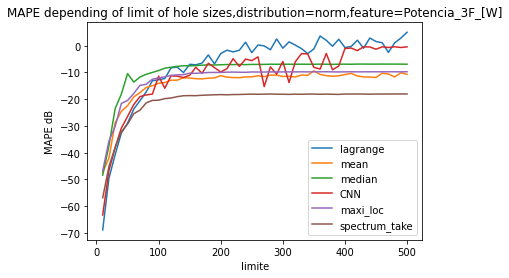

In [49]:
df_plot=df_result_2
X=lim_list2[:]
Y=[]
for j in methode_rempli_list:
  Y.append(df_plot.loc[df_plot["Filing method"]==j])
plt.plot(X,10*np.log(Y[0].iloc[:,8]),label="lagrange")
plt.xlabel("limite")
plt.ylabel("MAPE dB")
plt.title("MAPE depending of limit of hole sizes,distribution=norm,feature="+mesure[28])
plt.plot(X,10*np.log(Y[1].iloc[:,8]),label="mean")
plt.plot(X,10*np.log(Y[2].iloc[:,8]),label="median")
plt.plot(X,10*np.log(Y[3].iloc[:-1,8]),label="CNN")
plt.plot(X,10*np.log(Y[4].iloc[:-1,8]),label="maxi_loc")
plt.plot(X,10*np.log(Y[5].iloc[:-1,8]),label="spectrum_take")
plt.legend()
plt.show()